# Chapter 3 - Exercises

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint
from scipy.ndimage import shift

In [2]:
mnist = fetch_openml("mnist_784", as_frame=False)
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
# Seeing one image as an example
def plot_digit(image_data):
  image = image_data.reshape(28,28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")

### Exercise 1 - MNIST predictions over 97%

In [5]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [7]:
predictions_test = knn_clf.predict(X_test)
accuracy_score(y_test, predictions_test)

0.9688

In [20]:
# Randomized hyperparameter search for weights and n_neighbors
params_ditribs = {'weights': ['uniform', 'distance'],
                  'n_neighbors': randint(low=2, high=12)}

rnd_search = RandomizedSearchCV(knn_clf, param_distributions=params_ditribs, n_iter=7, cv=3,
                                scoring='accuracy', random_state=42, verbose=10)

rnd_search.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3; 1/7] START n_neighbors=8, weights=distance.............................
[CV 1/3; 1/7] END n_neighbors=8, weights=distance;, score=0.967 total time=   4.6s
[CV 2/3; 1/7] START n_neighbors=8, weights=distance.............................
[CV 2/3; 1/7] END n_neighbors=8, weights=distance;, score=0.966 total time=   4.6s
[CV 3/3; 1/7] START n_neighbors=8, weights=distance.............................
[CV 3/3; 1/7] END n_neighbors=8, weights=distance;, score=0.968 total time=   4.5s
[CV 1/3; 2/7] START n_neighbors=9, weights=uniform..............................
[CV 1/3; 2/7] END n_neighbors=9, weights=uniform;, score=0.964 total time=   4.7s
[CV 2/3; 2/7] START n_neighbors=9, weights=uniform..............................
[CV 2/3; 2/7] END n_neighbors=9, weights=uniform;, score=0.963 total time=   4.5s
[CV 3/3; 2/7] START n_neighbors=9, weights=uniform..............................
[CV 3/3; 2/7] END n_neighbors=9, weights=

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=7,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2e5701350>,
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='accuracy', verbose=10)

In [21]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="rank_test_score", ascending=True, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,0.088928,0.002500,4.560080,0.087145,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.96880,0.96795,0.96905,0.968600,0.000471,1
0,0.095942,0.010434,4.489381,0.052693,8,distance,"{'n_neighbors': 8, 'weights': 'distance'}",0.96715,0.96620,0.96845,0.967267,0.000922,2
2,0.089034,0.000809,4.494263,0.019169,6,uniform,"{'n_neighbors': 6, 'weights': 'uniform'}",0.96540,0.96520,0.96590,0.965500,0.000294,3
4,0.092069,0.003867,4.744605,0.062278,8,uniform,"{'n_neighbors': 8, 'weights': 'uniform'}",0.96365,0.96370,0.96570,0.964350,0.000955,4
1,0.090904,0.001315,4.488374,0.101832,9,uniform,"{'n_neighbors': 9, 'weights': 'uniform'}",0.96355,0.96290,0.96500,0.963817,0.000878,5


In [22]:
# Retrain best classifier on entire dataset
final_knn_clf = KNeighborsClassifier(n_neighbors=5, weights="distance")
final_knn_clf.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [23]:
predictions_test = final_knn_clf.predict(X_test)
accuracy_score(y_test, predictions_test)

0.9691

### Exercise 2 - training data augmentation

Adding augmented images to the dataset

In [4]:
def shift_images(images: np.ndarray, labels: np.ndarray, pixel_amount=2):
  images = images.reshape(len(images), 28,28)
  images_shifted = []
  labels_for_shifted = []
  for idx,image in enumerate(images):
    image_shifted_up = shift(image, [0, pixel_amount], mode="constant")
    image_shifted_down = shift(image, [0, -pixel_amount], mode="constant")
    image_shifted_left = shift(image, [-pixel_amount, 0], mode="constant")
    image_shifted_right = shift(image, [pixel_amount, 0], mode="constant")
    
    images_shifted.extend([image_shifted_up, image_shifted_down, image_shifted_left, image_shifted_right])
    labels_for_shifted.extend([labels[idx] for _ in range(4)])

  return np.array(images_shifted), np.array(labels_for_shifted)

images_shifted, labels_for_shifted = shift_images(X_train, y_train)

6


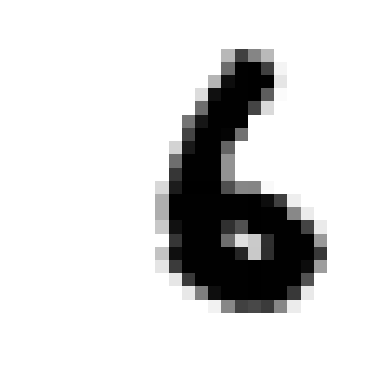

In [8]:
idx = 144
print (labels_for_shifted[idx])
plot_digit(images_shifted[idx])

In [10]:
# Add the augmented images to the train set and labels
images_shifted_reshaped = images_shifted.reshape(len(images_shifted), 784)
X_train_augmented = np.r_[X_train, images_shifted_reshaped]
print (X_train_augmented.shape)

y_train_augmented = np.r_[y_train, labels_for_shifted]
print (y_train_augmented.shape)

# Shuffle the training set and labels
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]


(300000, 784)
(300000,)


In [11]:
knn_clf = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(weights='distance')

In [13]:
predictions_test = knn_clf.predict(X_test)
accuracy_score(y_test, predictions_test)

0.9691